# 0. Librerias necesarias

In [3]:
import warnings 
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy import ndimage
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                            precision_score, recall_score, f1_score, roc_curve, auc)

# 1. Análisis Exploratrorio

Descripcion de las bases:


1. ORIGA(-light) contiene 650 imágenes retinianas anotadas por profesionales formados del Instituto de Investigación Ocular de Singapur.

    La base de datos está compuesta por un conjunto de imágenes y un archivo en formato CSV que contiene las columnas que se aprecian a continuación:

    Las  columnas (Image, CDR, Ecc-Cup, Ecc-Disc)  corresponden a variables explicativas y la última (Glaucoma) corresponde a nuestra variable clasificatoria.

    Cada una de estas columnas se explica de la siguiente manera:


    - Image: Nombre de archivo de imagen.
    - Source: Fuente del dato
    - CDR: Cup-to-Disc Ratio. Proporción entre el diámetro del "cup" (excavación central) y el disco óptico. Valor clave en la detección de glaucoma..
    - Ecc-Cup: Excentricidad de la región de excavación del nervio óptico (cup). Una medida morfológica.
    - Ecc-Disc: Excentricidad del disco óptico completo. Ayuda a describir la forma del disco.
    - Glaucoma: Variable clasificatoria que identifica el diagnóstico negativo (0) o positivo (1) del glaucoma

2. G1020 esta base de datos consta de 1020 imágenes de fondo de ojo en color de alta resolución y proporciona anotaciones de la verdad fundamental para el diagnóstico del glaucoma.

    La base de datos está compuesta por un conjunto de imágenes y un archivo en formato CSV en donde se encuentra el label de la variable predictora (Glaucoma)

Cargamos las bases

In [34]:
import os
import numpy as np

folder_path = "./datos/ICESI/negative/"
files_with_path = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
print(files_with_path)

icesi_negatives = np.array([[f, "ICESI", 0] for f in files_with_path])
print(icesi_negatives)

folder_path = "./datos/ICESI/positive/"
files_with_path = [os.path.join(folder_path, f) for f in os.listdir(folder_path)]
print(files_with_path)

icesi_positives = np.array([[f, "ICESI", 1] for f in files_with_path])
print(icesi_positives)

# Concatenate the two arrays and create a dataframe
icesi_all = np.concatenate([icesi_negatives, icesi_positives], axis=0)
df_icesi = pd.DataFrame(icesi_all, columns=["Image", "Source","Glaucoma"])

df_icesi["Glaucoma"] = df_icesi["Glaucoma"].astype("category").cat.codes.astype("int64")


['./datos/ICESI/negative/00053.png', './datos/ICESI/negative/00045.png', './datos/ICESI/negative/00051.png', './datos/ICESI/negative/00079.png', './datos/ICESI/negative/00078.png', './datos/ICESI/negative/00050.png', './datos/ICESI/negative/00044.png', './datos/ICESI/negative/00083.png', './datos/ICESI/negative/00068.png', './datos/ICESI/negative/00040.png', './datos/ICESI/negative/00055.png', './datos/ICESI/negative/00041.png', './datos/ICESI/negative/00069.png', './datos/ICESI/negative/00082.png', './datos/ICESI/negative/00080.png', './datos/ICESI/negative/00043.png', './datos/ICESI/negative/00081.png', './datos/ICESI/negative/00025.png', './datos/ICESI/negative/00019.png', './datos/ICESI/negative/00024.png', './datos/ICESI/negative/00026.png', './datos/ICESI/negative/00027.png', './datos/ICESI/negative/00023.png', './datos/ICESI/negative/00037.png', './datos/ICESI/negative/00036.png', './datos/ICESI/negative/00008.png', './datos/ICESI/negative/00020.png', './datos/ICESI/negative/000

In [35]:
df_icesi.head()

,Image,Source,Glaucoma
0,./datos/ICESI/negative/00053.png,ICESI,0
1,./datos/ICESI/negative/00045.png,ICESI,0
2,./datos/ICESI/negative/00051.png,ICESI,0
3,./datos/ICESI/negative/00079.png,ICESI,0
4,./datos/ICESI/negative/00078.png,ICESI,0


In [36]:
df_icesi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image     102 non-null    object
 1   Source    102 non-null    object
 2   Glaucoma  102 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 2.5+ KB


In [4]:
df_origa = pd.read_csv("./datos/ORIGA/origa_info.csv")
df_g1020 = pd.read_csv("./datos/G1020/G1020.csv")
df_refuge_train = pd.read_json("./datos/REFUGE/train/index.json", orient='index')
df_refuge_test = pd.read_json("./datos/REFUGE/test/index.json", orient='index') ## esta no tiene label

In [76]:
df_g1020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   imageID       1020 non-null   object
 1   binaryLabels  1020 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 16.1+ KB


In [77]:
df_g1020

,imageID,binaryLabels
0,image_0.jpg,0
1,image_1.jpg,0
2,image_3.jpg,0
3,image_4.jpg,0
4,image_5.jpg,0
...,...,...
1015,image_3198.jpg,0
1016,image_3199.jpg,0
1017,image_3201.jpg,1
1018,image_3202.jpg,1


In [78]:
df_origa

,Image,Source,Cropped,CDR,Ecc-Cup,Ecc-Disc,Label
0,001.jpg,Origa,True,0.7097,0.636027,0.580909,0
1,002.jpg,Origa,True,0.6953,0.575024,0.608413,0
2,003.jpg,Origa,True,0.9629,0.299303,0.262828,0
3,004.jpg,Origa,True,0.7246,0.503186,0.483273,0
4,005.jpg,Origa,True,0.6138,0.500141,0.283467,0
...,...,...,...,...,...,...,...
645,646.jpg,Origa,True,0.6560,0.123190,0.264288,1
646,647.jpg,Origa,True,0.7365,0.602515,0.528356,1
647,648.jpg,Origa,True,0.5101,0.295414,0.549101,1
648,649.jpg,Origa,True,0.5227,0.624191,0.383839,0


Unificamos los dataframes

In [79]:
df_refuge_train

,ImgName,Fovea_X,Fovea_Y,Size_X,Size_Y,Label
0,g0001.jpg,1057.95,1076.52,2124,2056,1
1,g0002.jpg,1190.59,1017.09,2124,2056,1
2,g0003.jpg,1070.56,1084.85,2124,2056,1
3,g0004.jpg,1072.60,1035.48,2124,2056,1
4,g0005.jpg,1058.19,1100.33,2124,2056,1
...,...,...,...,...,...,...
395,n0356.jpg,1229.73,1043.89,2124,2056,0
396,n0357.jpg,1080.45,1081.30,2124,2056,0
397,n0358.jpg,1288.78,1122.37,2124,2056,0
398,n0359.jpg,1239.17,1077.17,2124,2056,0


In [5]:
#Identifico la base
df_origa['Source'] = 'ORIGA'
df_g1020['Source'] = 'G1020'
df_refuge_train['Source'] = 'REFUGE' 

#Renombro columnas
df_g1020 = df_g1020.rename(columns={'imageID': 'Image','binaryLabels': 'Glaucoma'})
df_origa = df_origa.rename(columns={'Label': 'Glaucoma'})
df_refuge_train = df_refuge_train.rename(columns={'ImgName': 'Image','Label': 'Glaucoma'})

#Uno las bases
df_glacuoma = pd.concat([df_origa[['Image', 'Source', 'Glaucoma']]
                      #,df_g1020[['Image', 'Source', 'Glaucoma']]
                      #,df_refuge_train[['Image', 'Source', 'Glaucoma']]
                      #,df_icesi[['Image', 'Source', 'Glaucoma']]
                      ],
                      ignore_index=True)


conteo = df_glacuoma.groupby('Source').size().reset_index(name='Cantidad')
print(conteo)

df_glacuoma.head

  Source  Cantidad
0  ORIGA       650


<bound method NDFrame.head of        Image Source  Glaucoma
0    001.jpg  ORIGA         0
1    002.jpg  ORIGA         0
2    003.jpg  ORIGA         0
3    004.jpg  ORIGA         0
4    005.jpg  ORIGA         0
..       ...    ...       ...
645  646.jpg  ORIGA         1
646  647.jpg  ORIGA         1
647  648.jpg  ORIGA         1
648  649.jpg  ORIGA         0
649  650.jpg  ORIGA         1

[650 rows x 3 columns]>

Revisamos la proporción de la variable objetivo:

In [39]:
labels_counts = df_glacuoma["Glaucoma"].value_counts()
labels_counts

Glaucoma
0    482
1    168
Name: count, dtype: int64

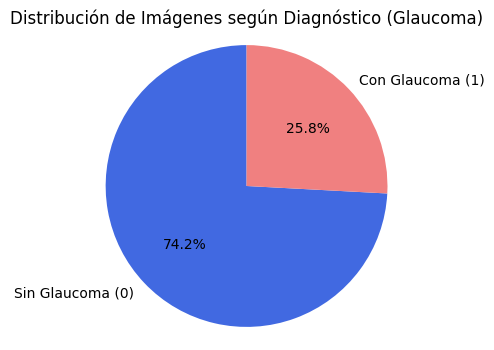

In [40]:
plt.figure(figsize=(4, 4))
plt.pie(labels_counts, 
        labels=['Sin Glaucoma (0)', 'Con Glaucoma (1)'],
        autopct='%1.1f%%',
        colors=['royalblue', 'lightcoral'],
        startangle=90)
plt.title('Distribución de Imágenes según Diagnóstico (Glaucoma)')
plt.axis('equal')  # Para que sea un círculo perfecto
plt.show()



Revisamos la distribución de CDR por la clasificación de Glaucoma (solo aplica para la base ORIGA)

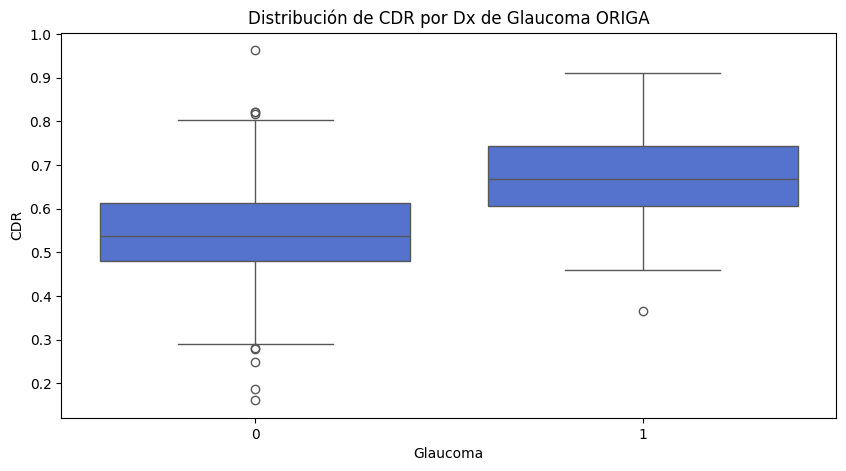

In [41]:
plt.figure(figsize=(10,5))

sns.boxplot(x='Glaucoma', y='CDR', data=df_origa, color="royalblue")
plt.title('Distribución de CDR por Dx de Glaucoma ORIGA')
plt.show()


Agregamos la ruta completa de la imagen al dataset

In [6]:

# Rutas diferentes para cada base de datos
root_origa = "./datos/ORIGA/Images"
root_g1020 = "./datos/G1020/Images"
root_refuge = "./datos/REFUGE/train/Images"


# Función para aplicar la ruta correcta
def get_image_path(row):
    if row['Source'] == 'ORIGA':
        return os.path.join(root_origa, row['Image'])
    elif row['Source'] == 'G1020':
        return os.path.join(root_g1020, row['Image'])
    elif row['Source'] == 'REFUGE':
        return os.path.join(root_refuge, row['Image'])
    elif row['Source'] == 'ICESI':
        return row['Image']
    else:
        return None  # En caso de que no coincida con ninguna base

# Aplicar la función a cada fila para crear la columna 'Path'
df_glacuoma['Path'] = df_glacuoma.apply(get_image_path, axis=1)

# Verificar los resultados

df_glacuoma[df_glacuoma["Source"] == "REFUGE"].head()

,Image,Source,Glaucoma,Path


In [7]:
df_glacuoma[df_glacuoma["Source"] == "ICESI"].head()

,Image,Source,Glaucoma,Path


In [8]:
df_glacuoma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650 entries, 0 to 649
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image     650 non-null    object
 1   Source    650 non-null    object
 2   Glaucoma  650 non-null    int64 
 3   Path      650 non-null    object
dtypes: int64(1), object(3)
memory usage: 20.4+ KB


Las imágenes que provee el dataset corresponden a fondos oculares como las siguientes:

In [9]:
# Obtener ruta de una imagen con Glaucoma = 0 (sin glaucoma)
img_path_0 = df_glacuoma[(df_glacuoma["Glaucoma"] == 0) & (df_glacuoma["Source"] == "ORIGA")]["Path"].iloc[0]
img_path_0

'./datos/ORIGA/Images/001.jpg'

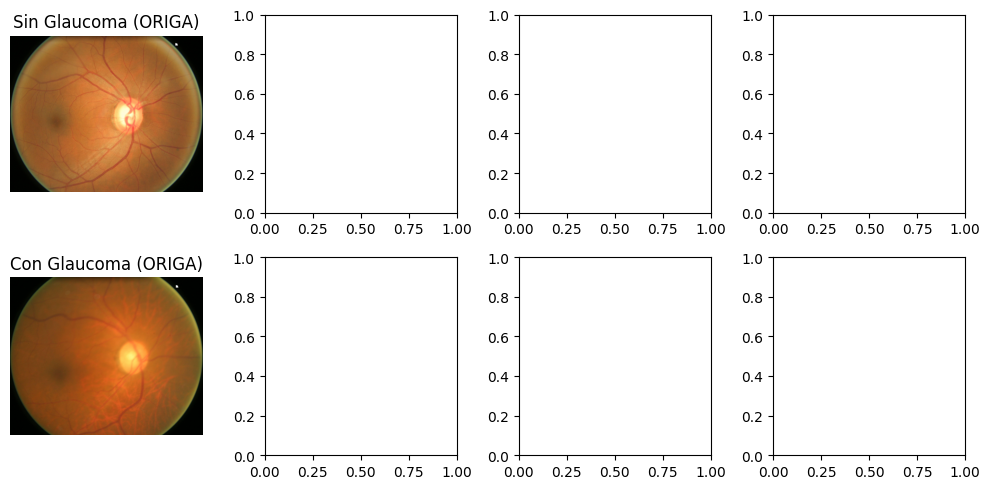

In [10]:
# Obtener ruta de una imagen con Glaucoma = 0 (sin glaucoma)
img_path_0 = df_glacuoma[(df_glacuoma["Glaucoma"] == 0) & (df_glacuoma["Source"] == "ORIGA")]["Path"].iloc[0]
img_0 = Image.open(img_path_0)

# # Obtener ruta de una imagen con Glaucoma = 1 (con glaucoma)
# img_path_1 = df_glacuoma[(df_glacuoma["Glaucoma"] == 0) & (df_glacuoma["Source"] == "G1020")]["Path"].iloc[0]
# img_1 = Image.open(img_path_1)

# # Obtener ruta de una imagen con Glaucoma = 1 (con glaucoma)
# img_path_2 = df_glacuoma[(df_glacuoma["Glaucoma"] == 0) & (df_glacuoma["Source"] == "REFUGE")]["Path"].iloc[0]
# img_2 = Image.open(img_path_2)

# # Obtener ruta de una imagen con Glaucoma = 1 (con glaucoma)
# #img_path_6 = df_glacuoma[(df_glacuoma["Glaucoma"] == 0) & (df_glacuoma["Source"] == "ICESI")]["Path"].iloc[0]
# #img_6 = Image.open(img_path_6)

# Obtener ruta de una imagen con Glaucoma = 0 (sin glaucoma)
img_path_3 = df_glacuoma[(df_glacuoma["Glaucoma"] == 1) & (df_glacuoma["Source"] == "ORIGA")]["Path"].iloc[0]
img_3 = Image.open(img_path_3)

# # Obtener ruta de una imagen con Glaucoma = 1 (con glaucoma)
# img_path_4 = df_glacuoma[(df_glacuoma["Glaucoma"] == 1) & (df_glacuoma["Source"] == "G1020")]["Path"].iloc[0]
# img_4 = Image.open(img_path_4)

# # Obtener ruta de una imagen con Glaucoma = 1 (con glaucoma)
# img_path_5 = df_glacuoma[(df_glacuoma["Glaucoma"] == 1) & (df_glacuoma["Source"] == "REFUGE")]["Path"].iloc[0]
# img_5 = Image.open(img_path_5)

# # Obtener ruta de una imagen con Glaucoma = 1 (con glaucoma)
# #img_path_7 = df_glacuoma[(df_glacuoma["Glaucoma"] == 1) & (df_glacuoma["Source"] == "ICESI")]["Path"].iloc[0]
# #img_7 = Image.open(img_path_7)

fig, axes = plt.subplots(2, 4, figsize=(10,5))

axes[0,0].imshow(img_0)
axes[0,0].set_title("Sin Glaucoma (ORIGA)")
axes[0,0].axis("off")

# axes[0,1].imshow(img_1)
# axes[0,1].set_title("Sin Glaucoma (G1020)")
# axes[0,1].axis("off")

# axes[0,2].imshow(img_2)
# axes[0,2].set_title("Sin Glaucoma (REFUGE)")
# axes[0,2].axis("off")

# axes[0,3].imshow(img_6)
# axes[0,3].set_title("Sin Glaucoma (ICESI)")
# axes[0,3].axis("off")

axes[1,0].imshow(img_3)
axes[1,0].set_title("Con Glaucoma (ORIGA)")
axes[1,0].axis("off")

# axes[1,1].imshow(img_4)
# axes[1,1].set_title("Con Glaucoma (G1020)")
# axes[1,1].axis("off")

# axes[1,2].imshow(img_5)
# axes[1,2].set_title("Con Glaucoma (REFUGE)")
# axes[1,2].axis("off")

# axes[1,3].imshow(img_7)
# axes[1,3].set_title("Con Glaucoma (ICESI)")
# axes[1,3].axis("off")

plt.tight_layout()
plt.show()


Las imágenes anteriores muestran fondos oculares diagnosticados de glaucoma de forma negativa (fila superior) y positiva (fila inferior).

# 2. Feature Enginier

### 2.1. Extraer la Región de Interés (revisar)

Queremos trabajar solo con el área relevante con el fin de eliminar el "ruido" al momento de entrenar el modelo

In [ ]:
#tarda 5 min
images = []
threshs = []
images_cropped = []

for i, image_path in enumerate(df_glacuoma['Path']):

    # Cargar la imagen y convertirla a escala de grises
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Aplicar umbral para obtener una imagen binaria
    threshold = 200
    _, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

    # Detectar los contornos y seleccionar el más grande
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    if contours:
        # Contorno más grande (suponiendo que es el disco óptico)
        largest = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest)

        # Calcular un rectángulo delimitador alrededor del contorno y ampliar el área para incluir un margen.
        pad = 300
        x1 = max(x - pad, 0)
        y1 = max(y - pad, 0)
        x2 = min(x + w + pad, img.shape[1])
        y2 = min(y + h + pad, img.shape[0])

        # Recortar la imagen en función de las coordenadas calculadas.
        img_cropped = img[y1:y2, x1:x2]

        # Mostrar la imagen recortada
        # plt.imshow(img_cropped)
        # plt.show()
        # print('Imagen recortada')
    else:
        # # No se encontró ROI, mostrar imagen original
        # plt.imshow(img)
        # plt.show()
        print('No se encontro Región de Interés',image_path)

    images.append(img)    
    threshs.append(thresh)    
    images_cropped.append(img_cropped)   

KeyboardInterrupt: 

: 

A continuación, observamos el proceso que hace el codigo anterior, tomamos la imagen original e identificamos las zonas de mayor brillo, a partir de allí recortamos la región de interés

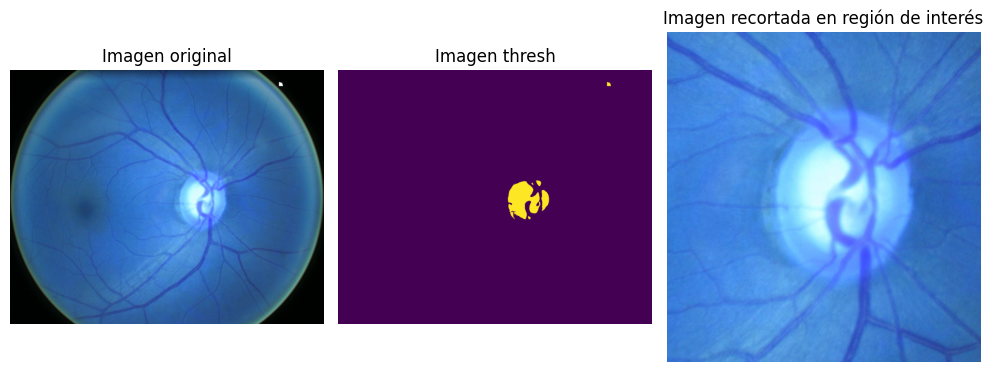

In [33]:
n = 0 # Selecciona la imagen

fig, axes = plt.subplots(1, 3, figsize=(10,5))

axes[0].imshow(images[n])
axes[0].set_title("Imagen original")
axes[0].axis("off")

axes[1].imshow(threshs[n])
axes[1].set_title("Imagen thresh")
axes[1].axis("off")

axes[2].imshow(images_cropped[n])
axes[2].set_title("Imagen recortada en región de interés")
axes[2].axis("off")

plt.tight_layout()
plt.show()  

### 2.2. Redimensionar

Reducimos el tamaño a algo uniforme (por ejemplo, 256x256 o 224x224) para que el modelo pueda recibir todas las imágenes del mismo tamaño

In [55]:
images_resize = []

for image in images:
    img_resize = cv2.resize(image, (256, 256)) #Redimensionar 
    # img_resize = cv2.resize(image, (224, 224)) #Redimensionar 
    images_resize.append(img_resize)  

del images ## borro para no saturar la RAM
del threshs ## borro para no saturar la RAM
del images_cropped ## borro para no saturar la RAM

plt.figure(figsize=(5,5))
plt.imshow(images_resize[0])  
plt.title("Imagen redimensionada")
# plt.axis("off")  
plt.show()


NameError: name 'images' is not defined

### 2.3. Conversión a escala de grises (Evaluar dependiendo del modelo)

CLAHE = Contrast Limited Adaptive Histogram Equalization


CLAHE es una técnica que mejora el contraste localmente, haciendo visibles detalles importantes, especialmente en imágenes médicas. Es útil en imágenes de retina para resaltar estructuras como el disco óptico y los vasos sanguíneos.

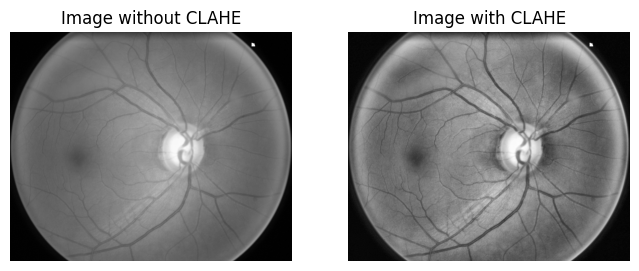

In [ ]:
sample_image_path= df_glacuoma.loc[0,'Path'] 
sample_image=cv2.imread(sample_image_path,cv2.IMREAD_GRAYSCALE)

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) # Parametros clave para los ajustes de contraste
image_clahe = clahe.apply(sample_image) 

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(sample_image,cmap = 'gray')
plt.title("Image without CLAHE")
plt.axis(False)

plt.subplot(1,2,2)
plt.imshow(image_clahe,cmap='gray')
plt.title("Image with CLAHE")
plt.axis(False)

plt.show()

Esta configuracion de CLAHE es recomentada para tratar con la imagenes de retina ya que permite mejorar el brillo y contraste sin alterar los colores

In [ ]:
images_clahe = []

for image in images_resize:

    ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) # Convierte la imagen de BGR a YCrCb, que es un espacio de color que separa la luminancia del color
    y = ycrcb[:, :, 0] 

    # Y = Luminancia (lo que percibimos como brillo) → este canal contiene la información de textura, bordes, contraste.
    # Cr, Cb = Información de color (crominancia, rojo y azul respectivamente).
    # Usar YCrCb permite mejorar el brillo y el contraste sin distorsionar los colores.

    # Aplicar CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    y_clahe = clahe.apply(y)

    # Reemplazar canal Y y convertir de nuevo
    ycrcb[:, :, 0] = y_clahe
    img_clahe = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR) #Convierte la imagen de vuelta a BGR, para poder visualizarla normalmente

    images_clahe.append(img_clahe) 

del images_resize ## borro para no saturar la RAM

Visualizamos la imagen luego de aplicar CLAHE, observamos que mejora el brillo y contraste lo que facilita identificar patrones relevantes en la detección de Glaucoma

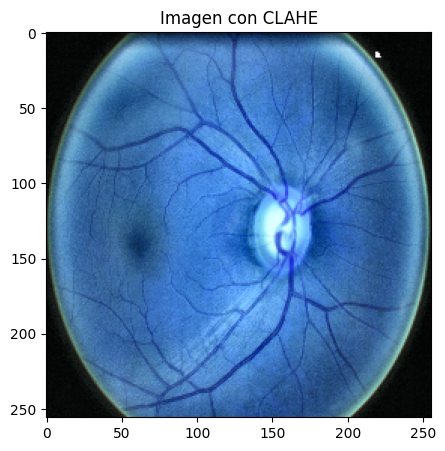

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(images_clahe[0])  
plt.title("Imagen con CLAHE")
# plt.axis("off")  
plt.show()

### 2.4. Normalizar

Normalizamos los valores de píxel a [0, 1] o [-1, 1]

In [ ]:
images_norm = []

for image in images_clahe:
    img_norm = image / 255.0  

    images_norm.append(img_norm) 

del images_clahe ## borro para no saturar la RAM

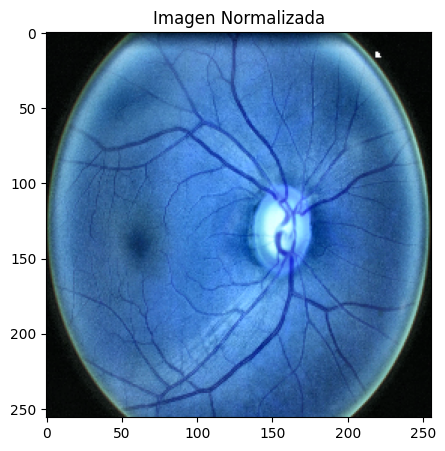

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(images_norm[0])  
plt.title("Imagen Normalizada")
# plt.axis("off")  
plt.show()

# 3. Modelo

Dividimos la variable objetivo de la variable explicativa

In [1]:
X = np.array(images_norm, dtype=np.float32)
y = df_glacuoma["Glaucoma"].values.astype(np.float32)

NameError: name 'np' is not defined

Aplanamos las imagenes para que puedan ser leidas por el modelo

In [ ]:
X_flat = X.reshape(X.shape[0], -1)  # Convierte cada imagen en un vector de una sola dimensión

Partimos la base de entranamiento y test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, stratify=y, random_state=42)

### 3.1. Random Forest

In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.76      0.99      0.86       313
         1.0       0.60      0.06      0.11       101

    accuracy                           0.76       414
   macro avg       0.68      0.52      0.49       414
weighted avg       0.72      0.76      0.68       414



In [11]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

NameError: name 'y_test' is not defined

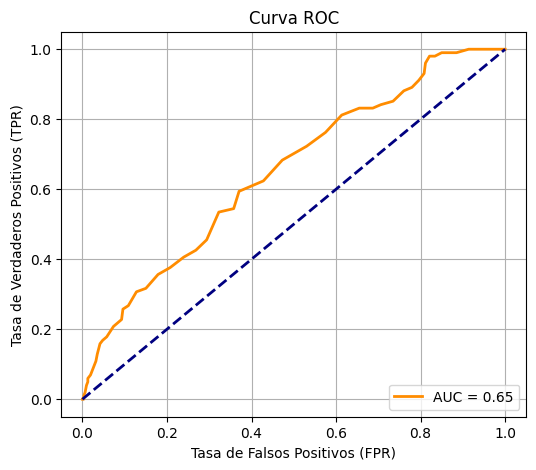

In [ ]:
y_proba = clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


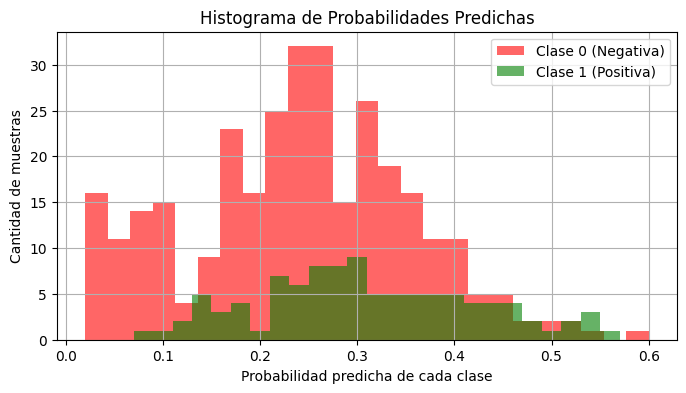

In [ ]:
plt.figure(figsize=(8, 4))

# Probabilidades para la clase 0
plt.hist(y_proba[y_test == 0], bins=25, alpha=0.6, color='red', label='Clase 0 (Negativa)')
# Probabilidades para la clase 1
plt.hist(y_proba[y_test == 1], bins=25, alpha=0.6, color='green', label='Clase 1 (Positiva)')


plt.title('Histograma de Probabilidades Predichas')
plt.xlabel('Probabilidad predicha de cada clase')
plt.ylabel('Cantidad de muestras')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Pendiente a implementar

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator


# train_datagen = ImageDataGenerator(
#     preprocessing_function = preprocess_input,
#     rotation_range=90,      # rotaciones aleatorias
#     horizontal_flip=True,   # voltear horizontalmente
#     vertical_flip=True      # voltear verticalmente
# )

# train_datagenerator = train_datagen.flow_from_dataframe(
#     dataframe=train_df,
#     directory='ORIGA/Images',
#     x_col='Path',
#     y_col='Glaucoma',
#     target_size=(256, 256),
#     batch_size=8,
#     class_mode='binary',
#     seed=42
# )

In [12]:
df_glacuoma.head()

,Image,Source,Glaucoma,Path
0,001.jpg,ORIGA,0,./datos/ORIGA/Images/001.jpg
1,002.jpg,ORIGA,0,./datos/ORIGA/Images/002.jpg
2,003.jpg,ORIGA,0,./datos/ORIGA/Images/003.jpg
3,004.jpg,ORIGA,0,./datos/ORIGA/Images/004.jpg
4,005.jpg,ORIGA,0,./datos/ORIGA/Images/005.jpg


In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow import keras
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [23]:
# --- Configuration ---
IMG_WIDTH, IMG_HEIGHT = 256, 256  # InceptionV3 default input size
BATCH_SIZE = 16
EPOCHS = 30 # Adjust as needed
LEARNING_RATE = 1e-4

Loaded 650 images and 650 labels.
Unique labels found: (array([0, 1]), array([482, 168]))


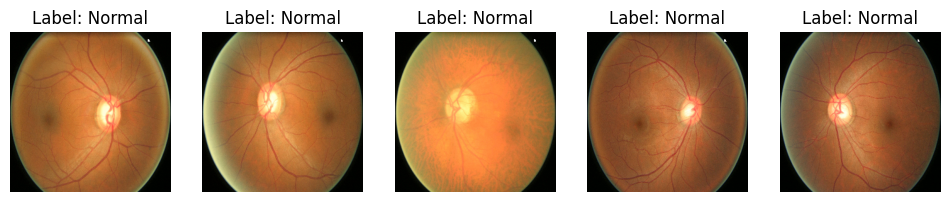

In [24]:
try:
    all_image_paths = df_glacuoma["Path"].values
    all_labels = df_glacuoma["Glaucoma"].values
    
    print(f"Loaded {len(all_image_paths)} images and {len(all_labels)} labels.")
    print(f"Unique labels found: {np.unique(all_labels, return_counts=True)}")

    # --- Sanity check: Display a few images with their labels ---
    plt.figure(figsize=(12, 6))
    for i in range(min(5, len(all_image_paths))):
        plt.subplot(1, 5, i + 1)
        img = load_img(all_image_paths[i], target_size=(IMG_WIDTH, IMG_HEIGHT))
        plt.imshow(img)
        plt.title(f"Label: {'Glaucoma' if all_labels[i] == 1 else 'Normal'}")
        plt.axis("off")
    plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure ORIGA_IMAGES_DIR and ORIGA_GLAUCOMA_LABELS_TXT are set correctly.")
    all_image_paths, all_labels = [], [] # Avoid further errors

if not all_image_paths.any() or not all_labels.any():
    print("No image paths or labels found. Please check the data loading process.")
    print("This may be due to missing or incorrectly specified data files.")
    print("Exiting the script.")
    exit()

In [25]:
# %%
# --- Split data into training and validation sets ---
# Stratify to ensure similar class distribution in train and val
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_labels,
    test_size=0.2,  # 20% for validation
    random_state=42,
    stratify=all_labels # Important for potentially imbalanced datasets
)

In [26]:
print(f"Training samples: {len(train_paths)}, Validation samples: {len(val_paths)}")
print(f"Train labels distribution: {np.unique(train_labels, return_counts=True)}")
print(f"Validation labels distribution: {np.unique(val_labels, return_counts=True)}")


Training samples: 520, Validation samples: 130
Train labels distribution: (array([0, 1]), array([386, 134]))
Validation labels distribution: (array([0, 1]), array([96, 34]))


In [27]:
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = preprocess_input(image) # InceptionV3 specific preprocessing
    return image, label

In [28]:
# Data Augmentation Layer
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1), # 0.25*2pi = 90 degrees
    # keras.layers.RandomZoom(0.1),
    # keras.layers.RandomContrast(0.1), # Be careful with contrast for medical images
    # keras.layers.RandomBrightness(0.1),
])



In [29]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = (
    train_ds
    .shuffle(buffer_size=len(train_paths))
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE) # Apply augmentation
    .prefetch(buffer_size=AUTOTUNE)
)

In [30]:
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = (
    val_ds
    .map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

In [31]:
# --- Verify dataset output shapes ---
for images, labels in train_ds.take(1):
    print("Images shape:", images.shape) # (BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH, 3)
    print("Labels shape:", labels.shape) # (BATCH_SIZE,)

Images shape: (16, 256, 256, 3)
Labels shape: (16,)


2025-05-29 20:24:04.259380: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [32]:
# %% [markdown]
# ## 3. Build the Model (InceptionV3 for Transfer Learning)

# %%
# --- Load pre-trained InceptionV3 model ---
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

In [33]:
# --- Freeze the base model layers ---
# We start by freezing all layers of the base model.
# We might unfreeze some later for fine-tuning.
base_model.trainable = False

In [34]:
# --- Add custom classification head ---
inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False) # Ensure base_model runs in inference mode here
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # Regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x) # Binary classification (0 or 1)

model = Model(inputs, outputs)

# --- Compile the model ---
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 6, 6, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,327,585 (85.17 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [36]:
# %% [markdown]
# ## 4. Train the Model

# %%
# --- Callbacks ---
# Save the best model
checkpoint_filepath = 'best_glaucoma_inceptionv3_model.keras' # Use .keras extension
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_auc', # Or 'val_accuracy' or 'val_loss'
    mode='max', # For 'val_auc' or 'val_accuracy', use 'min' for 'val_loss'
    save_best_only=True)

# Early stopping
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_auc', # Or 'val_loss'
    patience=10,        # Number of epochs with no improvement after which training will be stopped
    mode='max',         # For AUC/accuracy, 'min' for loss
    restore_best_weights=True # Restores model weights from the epoch with the best value of the monitored quantity.
)


In [37]:
#--- Calculate class weights for imbalanced datasets (Optional but recommended) ---
#If your dataset is imbalanced (e.g., many more normals than glaucoma),
#class weights can help the model pay more attention to the minority class.
counts = np.bincount(all_labels)
weight_for_0 = (1 / counts[0]) * (len(all_labels) / 2.0) if counts[0] > 0 else 0
weight_for_1 = (1 / counts[1]) * (len(all_labels) / 2.0) if counts[1] > 0 else 0
class_weight = {0: weight_for_0, 1: weight_for_1}
print(f"Class weights: {class_weight}")
#Use this in model.fit() if needed: `class_weight=class_weight`

Class weights: {0: np.float64(0.6742738589211619), 1: np.float64(1.9345238095238093)}


In [38]:
# --- Train the model ---
print("Starting training...")
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[model_checkpoint_callback, early_stopping_callback],
    class_weight=class_weight # Uncomment if using class weights
)
print("Training finished.")

Starting training...
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 378ms/step - accuracy: 0.4836 - auc: 0.4217 - loss: 0.9127 - val_accuracy: 0.7308 - val_auc: 0.5766 - val_loss: 0.6050
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 391ms/step - accuracy: 0.5940 - auc: 0.5343 - loss: 0.7583 - val_accuracy: 0.5077 - val_auc: 0.6238 - val_loss: 0.6989
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 368ms/step - accuracy: 0.5821 - auc: 0.5824 - loss: 0.6839 - val_accuracy: 0.5231 - val_auc: 0.6432 - val_loss: 0.6949
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 363ms/step - accuracy: 0.5769 - auc: 0.6167 - loss: 0.6824 - val_accuracy: 0.6000 - val_auc: 0.6631 - val_loss: 0.6596
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 355ms/step - accuracy: 0.5973 - auc: 0.6477 - loss: 0.6732 - val_accuracy: 0.6077 - val_auc: 0.6608 - val_loss: 0.6602
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 354ms/step - accuracy: 0.6059 - auc: 0.6567 - loss: 0.6618 - val_accuracy: 0.6077 - val_auc: 0.6610 - val_loss: 0.6773
Epoch 7/30
33

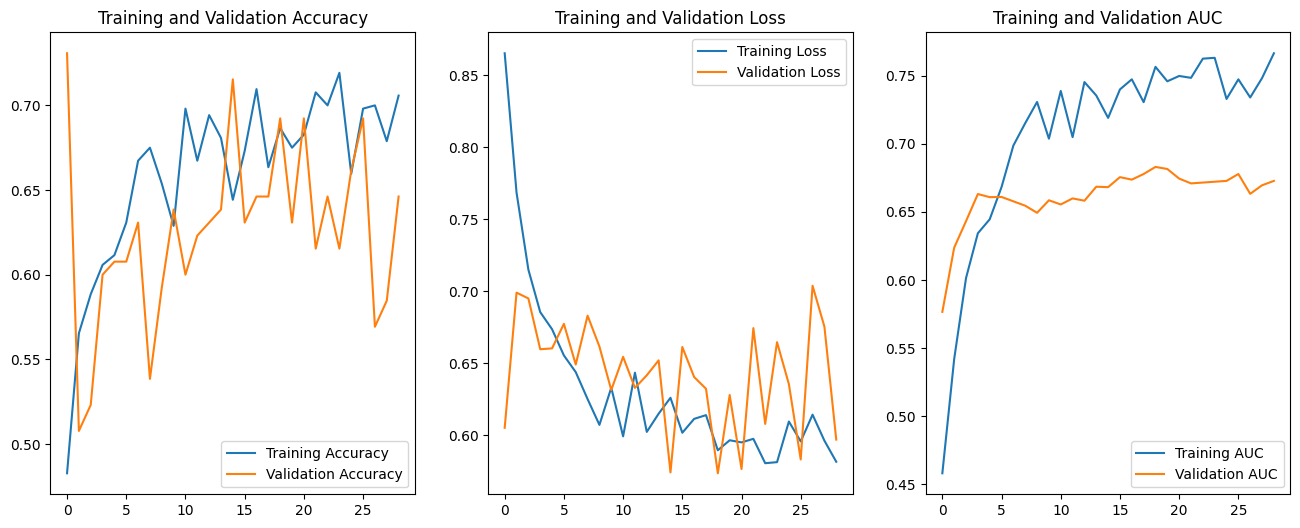

In [39]:
# ## 5. Evaluate the Model

# %%
# --- Load the best saved model (if EarlyStopping restored best weights, this might not be strictly necessary but good practice) ---
# If early_stopping_callback had restore_best_weights=True, model already has best weights.
# Otherwise, load explicitly:
# best_model = keras.models.load_model(checkpoint_filepath)
# For simplicity, we'll use the current 'model' if restore_best_weights=True was used.
# If you saved with .h5, use keras.models.load_model. If .keras, it's also keras.models.load_model

# --- Plot training history ---
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    auc = history.history.get('auc', []) # .get handles if 'auc' is not present
    val_auc = history.history.get('val_auc', [])

    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    if auc and val_auc:
        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, auc, label='Training AUC')
        plt.plot(epochs_range, val_auc, label='Validation AUC')
        plt.legend(loc='lower right')
        plt.title('Training and Validation AUC')

    plt.show()

plot_history(history)


Evaluating on validation data...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 224ms/step - accuracy: 0.7272 - auc: 0.7127 - loss: 0.5644
Validation Loss: 0.5734
Validation Accuracy: 69.23%
Validation AUC: 0.6831
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 234ms/step

Classification Report:
              precision    recall  f1-score   support

  Normal (0)       0.88      0.38      0.53        96
Glaucoma (1)       0.33      0.85      0.47        34

    accuracy                           0.50       130
   macro avg       0.60      0.61      0.50       130
weighted avg       0.73      0.50      0.51       130


Confusion Matrix:


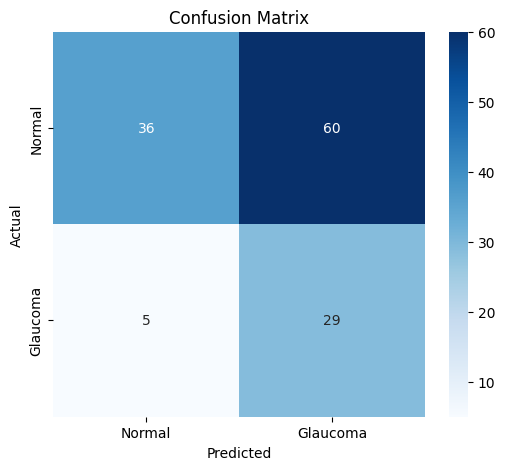

In [43]:
# %%
# --- Evaluate on the validation set ---
print("\nEvaluating on validation data...")
results = model.evaluate(val_ds, verbose=1)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Accuracy: {results[1]*100:.2f}%")
if len(results) > 2:
    print(f"Validation AUC: {results[2]:.4f}")


# # Buscar el mejor threshold según F1
# thresholds = np.linspace(0, 1, 1000)
# f1s = [balanced_accuracy_score(y_true, y_proba > t) for t in thresholds]
# # f1s = [f1_score(y_true, y_proba > t) for t in thresholds]
# best_th = thresholds[np.argmax(f1s)]


# --- Get predictions for confusion matrix and classification report ---
val_predictions_probs = model.predict(val_ds)
val_predictions = (val_predictions_probs > 0.3).astype(int).flatten() # Convert probabilities to binary predictions

# True labels are already available in val_labels, but let's get them from val_ds to be sure order is maintained.
# This is a bit more involved with tf.data.Dataset if not already stored.
# We already have val_labels correctly ordered from train_test_split.

print("\nClassification Report:")
print(classification_report(val_labels, val_predictions, target_names=['Normal (0)', 'Glaucoma (1)']))

print("\nConfusion Matrix:")
cm = confusion_matrix(val_labels, val_predictions)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Glaucoma'],
            yticklabels=['Normal', 'Glaucoma'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [44]:
# %% [markdown]
# ## 6. Make Predictions on New Images (Example)

# %%
def predict_single_image(image_path, model_to_use):
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded)

    prediction_prob = model_to_use.predict(img_preprocessed)[0][0]
    prediction_class = "Glaucoma" if prediction_prob > 0.5 else "Normal"

    plt.imshow(img)
    plt.title(f"Prediction: {prediction_class} ({prediction_prob:.2f})")
    plt.axis("off")
    plt.show()
    return prediction_class, prediction_prob


--- Example Predictions ---

Predicting on image 1 of 3:
Actual label: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


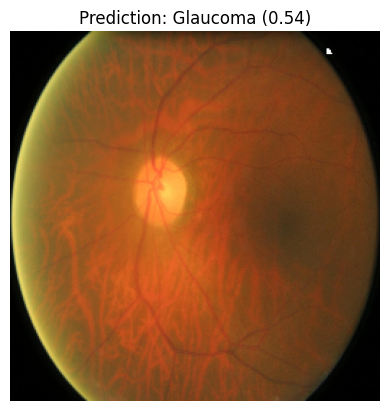


Predicting on image 2 of 3:
Actual label: Glaucoma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


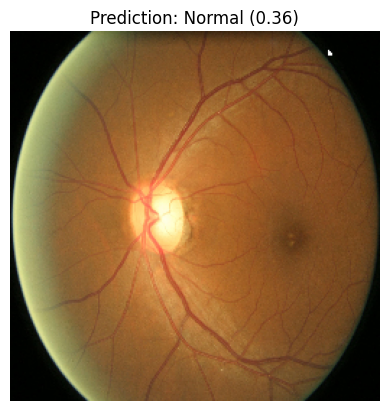


Predicting on image 3 of 3:
Actual label: Normal
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


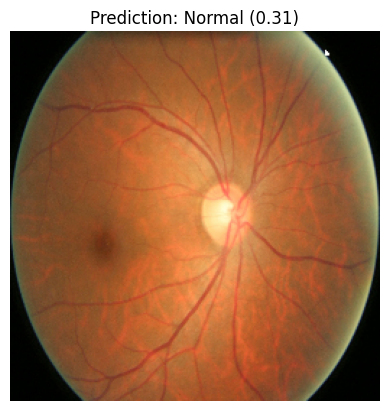

In [47]:
import random

# --- Example: Predict on a few validation images ---
# Make sure to load the best model if you didn't use restore_best_weights=True
# best_model = keras.models.load_model(checkpoint_filepath)

print("\n--- Example Predictions ---")
if len(val_paths) >= 3:
    for i in range(3):
        random_index = random.randint(0, len(val_paths) - 1)
        print(f"\nPredicting on image {i+1} of 3:")
        actual_label = "Glaucoma" if val_labels[random_index] == 1 else "Normal"
        print(f"Actual label: {actual_label}")
        predict_single_image(val_paths[random_index], model) # Use 'model' which should have best weights if restore_best_weights was True
else:
    print("Not enough validation images to show 3 examples.")